# EDA: Named Entity Recognition

Named entity recognition is the process of identifing particular elements from text, such as names, places, quantities, percentages, times/dates, etc. Identifying and quantifying what the general content types an article contains seems like a good predictor of what type of article it is. World news articles, for example, might mention more places than opinion articles, and business articles might have more percentages or dates than other sections. For each article, I'll count how many total mentions of people or places there are in the titles, as well as how many unique mentions for article bodies.

The Stanford NLP group has published three [Named-Entity Recognizers](http://nlp.stanford.edu/software/CRF-NER.shtml). The three class model recognizes locations, persons, and organizations, and at least for now, this is the one I'll be using. Although NER's are written in Java, there is the Pyner interface for Python, as well as an NLTK wrapper (which I'll be using).

Although state-of-the-art taggers can achieve near-human levels of accuracy, this one does make a few mistakes. One obvious flaw is that if I feed the tagger unigram terms, two-part names such as "Michael Jordan" will count as ("Michael", "PERSON") and ("Jordan", "PERSON"). I can roughly correct for this by dividing my average name entity count by two if need be. Additionally, sometimes the tagger mis-tags certain people or places. For instance, it failed to recognize "Cameroon" as a location, but tagged the word "Heartbreak" in the article title "A Personal Trainer for Heartbreak" as a person. That being said, let's see what it can do on my news data.

In [46]:
import articledata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator

In [13]:
data = pd.read_pickle('/Users/teresaborcuch/capstone_project/notebooks/pickled_data.pkl')

## Counting Named Entities

Here is my count_entities function. The idea is to count the total mentions of a person or a place in an article's body or title and save them as columns in my existing data structure.

In [ ]:
def count_entities(data = None, title = True):
    # set up tagger
    os.environ['CLASSPATH'] = "/Users/teresaborcuch/stanford-ner-2013-11-12/stanford-ner.jar"
    os.environ['STANFORD_MODELS'] = '/Users/teresaborcuch/stanford-ner-2013-11-12/classifiers'
    st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')

    tagged_titles = []
    persons = []
    places = []

    if title:

        for x in data['title']:
            tokens = word_tokenize(x)
            tags = st.tag(tokens)
            tagged_titles.append(tags)

        for pair_list in tagged_titles:
            person_count = 0
            place_count = 0
            for pair in pair_list:
                if pair[1] == 'PERSON':
                    person_count +=1
                elif pair[1] == 'LOCATION':
                    place_count +=1
                else:
                    continue
            persons.append(person_count)
            places.append(place_count)


        data['total_persons_title'] = persons
        data['total_places_title'] = places

    else:
        for x in data['body']:
            tokens = word_tokenize(x)
            tags = st.tag(tokens)
            tagged_titles.append(tags)

        for pair_list in tagged_titles:
            person_count = 0
            place_count = 0
            for pair in pair_list:
                if pair[1] == 'PERSON':
                    person_count +=1
                elif pair[1] == 'LOCATION':
                    place_count +=1
                else:
                    continue
            persons.append(person_count)
            places.append(place_count)

        data['total_persons_body'] = persons
        data['total_places_body'] = places

    return data

In [14]:
# Count people and places in article titles and save as new columns
# Warning - this is super slow! 
data = articledata.count_entities(data = data, title = True)

In [17]:
data.head(1)

,title,date,body,section,source,condensed_section,SA_body,SA_title,SA_diff,total_persons_title,total_places_title
0,$5 Million for a Super Bowl Ad. Another Millio...,2017-01-29,"This month, Anheuser-Busch InBev hosted a doze...",business,NYT,business,0.01624,-0.023148,0.039388,0,0


In [18]:
# pickle the file to avoid having to re-run this for future analyses
data.to_pickle('/Users/teresaborcuch/capstone_project/notebooks/ss_entity_data.pkl')

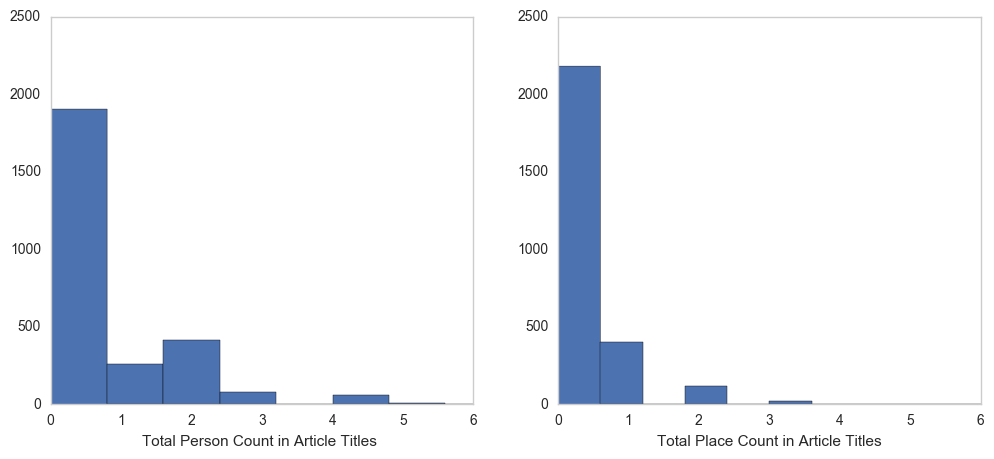

In [42]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize = (12, 5))

ax1 = fig.add_subplot(1,2,1)
ax1.hist(data['total_persons_title'])
ax1.set_xlabel("Total Person Count in Article Titles ")
ax1.set_ylim(0,2500)
ax1.set_xlim(0,6)

ax2 = fig.add_subplot(1,2,2)
ax2.hist(data['total_places_title'])
ax2.set_xlabel("Total Place Count in Article Titles")
ax2.set_ylim(0, 2500)
ax2.set_xlim(0,6)
plt.show()

These graphs indicate that person and place counts from article are both strongly right skewed. It might be more interesting to compare mean person and place counts among different sections.

In [45]:
data.pivot_table(
    index = ['condensed_section'], 
    values = ['total_persons_title', 'total_places_title']).sort_values('total_persons_title', ascending = False)

,total_persons_title,total_places_title
condensed_section,,
entertainment,0.981636,0.131886
sports,0.913793,0.254310
other,0.651741,0.164179
education,0.615385,0.269231
politics,0.573864,0.269886
opinion,0.523923,0.165072
world,0.376874,0.638116
business,0.339806,0.291262
technology,0.242424,0.111111


From this pivot table, it seems there are a few distinctions to be made between different sections. Entertainment and sports contain more person mentions on average than any other sections, and world news contains more places in the title than other sections.

## Finding Common Named Entities

Now, I'll try to see which people are places get the most mentions in each section. I've written an evaluate_entities function that creates a dictionary of counts for each unique person or place in a particular section or for a particular source.

In [ ]:
def evaluate_entities(data = None, section = None, source = None):
    section_mask = (data['condensed_section'] == section)
    source_mask = (data['source'] == source)

    if section and source:
        masked_data = data[section_mask & source_mask]

    elif section:
        masked_data = data[section_mask]

    elif source:
        masked_data = data[source_mask]

    else:
        masked_data = data

    # set up tagger
    os.environ['CLASSPATH'] = "/Users/teresaborcuch/stanford-ner-2013-11-12/stanford-ner.jar"
    os.environ['STANFORD_MODELS'] = '/Users/teresaborcuch/stanford-ner-2013-11-12/classifiers'
    st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')
    
    # dictionaries to hold counts of entities
    person_dict = {}
    place_dict = {}

    for x in masked_data['body']:
        tokens = word_tokenize(x)
        tags = st.tag(tokens)
        for pair in tags:
            if pair[1] == 'PERSON':
                if pair[0] not in person_dict.keys():
                    person_dict[pair[0]] = 1
                else:
                    person_dict[pair[0]] +=1
            elif pair[1] == 'LOCATION':
                if pair[0] not in place_dict.keys():
                    place_dict[pair[0]] = 1
                else:
                    place_dict[pair[0]] += 1

    return person_dict, place_dict

### Commonly Mentioned People in World News and Entertainment

In [19]:
world_persons, world_places = articledata.evaluate_entities(data = data, section = 'world', source = None)

In [47]:
# get top 20 people from world news article bodies
sorted_wp = sorted(world_persons.items(), key=operator.itemgetter(1))
sorted_wp.reverse()
sorted_wp[:20]

[(u'Trump', 1237),
 (u'Obama', 181),
 (u'Putin', 98),
 (u'Netanyahu', 97),
 (u'Mattis', 79),
 (u'Bannon', 75),
 (u'Flynn', 74),
 (u'Erdogan', 72),
 (u'Merkel', 72),
 (u'Donald', 66),
 (u'Fillon', 64),
 (u'Le', 63),
 (u'Al', 62),
 (u'Barack', 60),
 (u'Evola', 60),
 (u'John', 56),
 (u'Qaeda', 56),
 (u'Abe', 55),
 (u'Pen', 51),
 (u'Trudeau', 47)]

Perhaps as expected, Trump is the most commonly mentioned person in world news, with 1,237 mentions in 467 articles, with Obama and Putin coming in second and third. It's interesting to note that most of these names are political figures, but since the tagger only receives unigrams, partial names and first names are mentioned as well.

In [20]:
entertainment_persons, entertainment_places = articledata.evaluate_entities(data = data, section = 'entertainment', source = None)

In [34]:
sorted_ep = sorted(entertainment_persons.items(), key=operator.itemgetter(1))
sorted_ep.reverse()
sorted_ep[:20]

[(u'Trump', 287),
 (u'David', 151),
 (u'John', 109),
 (u'James', 86),
 (u'George', 82),
 (u'Stewart', 74),
 (u'Thomas', 67),
 (u'Robert', 61),
 (u'Donald', 60),
 (u'Michael', 57),
 (u'Smith', 55),
 (u'Peter', 51),
 (u'Meyers', 51),
 (u'Noah', 48),
 (u'Scott', 48),
 (u'Richard', 45),
 (u'de', 43),
 (u'Tom', 42),
 (u'Ivanka', 42),
 (u'Martin', 40)]

Now, I'll compare the top 20 people mentioned in entertainment articles. Trump still takes the number one spot, but interestingly, he's followed by a string of first names. NLTK provides a corpus of male and female-tagged first names, so counting the number of informal mentions or even the ratio of men to women might be a useful feature for classifying articles.

### Commonly Mentioned Places in World News and Entertainment

Compared to those from the world news section, the locations in the entertainment section are mostly in the United States: New York City (pieced together from "New", "York", and "City") seems to be the most common, but Los Angeles, Manhattan, and Chicago also appear. There are a few international destinations (fashionable ones like London and Paris and their respective countries), but nowhere near as many as in the world news section, where, after the U.S, Iran, China, and Russia take the top spots.

In [51]:
# get top 20 places from world news article bodies
sorted_wp = sorted(world_places.items(), key=operator.itemgetter(1))
sorted_wp.reverse()
sorted_wp[:20]

[(u'United', 764),
 (u'States', 699),
 (u'U.S.', 426),
 (u'Iran', 324),
 (u'China', 260),
 (u'Russia', 214),
 (u'Syria', 199),
 (u'Israel', 194),
 (u'Washington', 173),
 (u'Turkey', 167),
 (u'Iraq', 144),
 (u'France', 138),
 (u'Europe', 133),
 (u'West', 115),
 (u'Germany', 113),
 (u'Britain', 110),
 (u'South', 104),
 (u'Yemen', 104),
 (u'Mexico', 103),
 (u'Bank', 102)]

In [52]:
# get top 20 places from entertainment article bodies
sorted_ep = sorted(entertainment_places.items(), key=operator.itemgetter(1))
sorted_ep.reverse()
sorted_ep[:20]

[(u'New', 283),
 (u'York', 251),
 (u'United', 127),
 (u'States', 113),
 (u'Washington', 108),
 (u'London', 85),
 (u'America', 84),
 (u'Los', 80),
 (u'Angeles', 79),
 (u'Paris', 79),
 (u'City', 62),
 (u'France', 44),
 (u'Manhattan', 43),
 (u'Chicago', 42),
 (u'San', 35),
 (u'Europe', 35),
 (u'West', 34),
 (u'California', 33),
 (u'England', 32),
 (u'Britain', 28)]